# Modelisation joueur  


Imporations des dépendances

In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import math
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pickle



In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Définissez l'appareil sur GPU
    print("GPU disponible :", torch.cuda.get_device_name(0))  # Affiche le nom du GPU
else:
    device = torch.device("cpu")  # Définissez l'appareil sur CPU
    print("GPU non disponible, utilisation du CPU.")

GPU disponible : NVIDIA RTX A4000



## Modele
  
### Bloc Transformer

In [3]:
class Attention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim,):
        super(Attention, self).__init__()

        self.sqrt_hidden_dim = math.sqrt(hidden_dim)

        self.wq = nn.Parameter(torch.randn(hidden_dim, x_to_dim)).to(device)
        
        self.wk = nn.Parameter(torch.randn(hidden_dim, x_from_dim)).to(device)
        self.wv = nn.Parameter(torch.randn(x_to_dim, x_from_dim)).to(device)

    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]

        # les lettres dans les einsum :
        # b : le batch
        # x, y, z: la taille de l'ensemble (x_from ou x_to)
        # i,j : les éléments des vecteurs de x_from, x_to / les éléments de ces vecteurs une fois projetés (via Wq, Wk ou Wv)

        q = torch.einsum('ik,bxk->bxi',self.wq,x_to) # un tenseur de dimension (batch size, x_to_len, Dq)

        k = torch.einsum('ij,bxj->bxi',self.wk,x_from) # un tenseur de dimension (batch size, x_from_len, Dk=Dq)
        v = torch.einsum('ij,bxj->bxi',self.wv,x_from) # un tenseur de dimension (batch size, x_from_len, Dv)

        e = torch.softmax(torch.einsum('bxi,byi->bxy', q, k)/self.sqrt_hidden_dim, dim=1) # un tenseur de dimension (batch size, x_to_len, x_from_len)

        attention = torch.einsum('bxy,byi->bxi', e, v) # un tenseur de dimension (batch size, x_to_len, Dv)

        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, x_to_dim, x_from_dim, hidden_dim, n_heads):
        super(MultiHeadAttention, self).__init__()
        heads_list = []
        for _ in range(n_heads):
            att = Attention(x_to_dim, x_from_dim, hidden_dim)
            heads_list.append(att)
        
        self.heads_list = heads_list
        self.output_projection = nn.Parameter(torch.randn(n_heads)).to(device)

    def forward(self, x_to, x_from):
        # x_to = [batch size, x_to_len, x_to_dim]
        # x_from = [batch size, x_from_len, x_from_dim]
        attention_list = []

        for head in self.heads_list:
            attention_list.append(head(x_to, x_from)) 

        concat = torch.stack(attention_list) # on obtient ainsi un tenseur représentant la concaténation des résultats des différentes "heads"

        result = torch.einsum('hbxi,h->bxi', concat, self.output_projection)

        return result

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, x_to_dim, hidden_dim, n_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.multhead = MultiHeadAttention(x_to_dim, x_to_dim, hidden_dim, n_heads)
    
    def forward(self, x_to):
        return self.multhead(x_to, x_to)

class LayerNorm(nn.Module):
    def __init__(self):
        super(LayerNorm, self).__init__()

    def forward(self, x):
        norm_x = torch.norm(x, dim=1).unsqueeze(1).expand_as(x)

        return x/norm_x

class FFN(nn.Sequential):
    def __init__(self, input_dim, dropout_rate=0.1, expansion_factor=2):
        super(FFN, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, input_dim*expansion_factor)
        self.dropout_layer = nn.Dropout(p = dropout_rate)
        self.output_layer = nn.Linear(input_dim*expansion_factor, input_dim)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = nn.LeakyReLU(negative_slope=0.1)(self.dropout_layer(x))
        x = self.output_layer(x)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, data_dim, hidden_dim, n_heads, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()

        self.bloc_self_attention = MultiHeadSelfAttention(data_dim, hidden_dim, n_heads)

        self.bloc_normalization_1 = LayerNorm()

        self.bloc_FFN = FFN(data_dim, dropout_rate=dropout_rate)

        self.bloc_normalization_2 = LayerNorm()
        # It's useless to use 2 LayerNorm, cause they are the same. 
        # Yet, because it's my first transformer,
        # I will keep both of them for clarity in my mind


    def forward(self, x):
        # x = [batch size, x_len, hidden dim]
        identity = x
        x = self.bloc_self_attention(x)
        x = self.bloc_normalization_1(x+identity)

        identity = x
        x = self.bloc_FFN(x)
        x = self.bloc_normalization_2(x+identity)

        return x

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len, const = 10000):
        super(SinusoidalPositionalEncoding, self).__init__()

        self.pe = torch.zeros(max_len, hidden_dim).to(device)

        for i in range(max_len):
            for j in range(hidden_dim):
                if j%2==0:
                    self.pe[i, j] = math.sin(i/(const**(j/hidden_dim)))
                else:
                    self.pe[i, j] = math.cos(i/(const**((j-1)/hidden_dim)))

    def forward(self, x):
        # x = [batch size, len_x, dim_vect_de_x]
        dim_batch = x.size(0) # dimension du batch
        for k in range(dim_batch):
            x[k] += self.pe[:x[k].size(0),:] # on somme le tenseur PE sur chaque élément du batch
        return x

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len):
        super(LearnedPositionalEncoding, self).__init__()

        self.pe = nn.Parameter(torch.randn(max_len, hidden_dim)).to(device)


    def forward(self, x):
        dim_batch = x.size(0) # dimension du batch
        for k in range(dim_batch):
            x[k] += self.pe[:x[k].size(0),:] # on somme le tenseur PE sur chaque élément du batch
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, data_dim,  hidden_dim, n_heads, n_layers, dropout_rate=0.1, positional_encoding="sinusoidal", max_len=1000):
        super(TransformerEncoder, self).__init__()
        if positional_encoding == "sinusoidal":
            self.layer_positional_encoding = SinusoidalPositionalEncoding(data_dim, max_len)
        else:
            self.layer_positional_encoding = LearnedPositionalEncoding(data_dim, max_len)
        
        self.bloc_transformer_list = nn.ModuleList([TransformerEncoderBlock(data_dim, hidden_dim, n_heads, dropout_rate) for i in range(n_layers)])

    def forward(self, x, mask):
        x = self.layer_positional_encoding(x)

        for transformer_block in self.bloc_transformer_list:
            x = transformer_block(x) * mask

        return x
    


### Modele global

In [4]:
class MLP(nn.Module):
    def __init__(self, layers_sizes):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(in_features=layers_sizes[i], out_features=layers_sizes[i+1]) for i in range(len(layers_sizes)-1)])

    def forward(self, x):
        for layer in self.layers:
            x = nn.LeakyReLU()(layer(x))
        return x


class PlayerModel(nn.Module):
    def __init__(self, layer_size_embedding, layer_size_output, hidden_dim_transformer, n_heads_transformer, n_layers_transformer, max_len_for_encoding):
        super(PlayerModel, self).__init__()

        self.dim_embedding = layer_size_embedding[-1]

        self.embedding_layer = MLP(layers_sizes=layer_size_embedding)

        self.transformer_encoder = TransformerEncoder(data_dim = self.dim_embedding, hidden_dim = hidden_dim_transformer, n_heads = n_heads_transformer, n_layers = n_layers_transformer, positional_encoding="learned", max_len=max_len_for_encoding)

        self.decoder = MLP(layers_sizes=layer_size_output)

    def forward(self, x):

        mask = self.make_mask(x, self.dim_embedding)

        x = self.embedding_layer(x)
        x = self.transformer_encoder.forward(x, mask)[:,0,:]
        x = self.decoder(x)

        return x

    def make_mask(self, x, dim_embedding):
        mask = (x>-50.).float().to(device)
        
        return torch.cat((mask, mask, mask, mask), dim=2)[:,:,:dim_embedding]


## Entrainement

### Fonctions annexes

Datasets : 

In [14]:
with open("./data_transformer_duplicated", "rb") as temp:
    data = pickle.load(temp)

maxlen = 0
for sequence, reponse in data:
    if len(sequence)>maxlen:
        maxlen = len(sequence)

print("maxlen = ", maxlen)

for sequence, response in data:
    for _ in range(len(sequence), maxlen):
        sequence.append([0., 0., 0., 0., 0., 0., 0., 0., 0.])

data_for_train = data[:50000*24]
data_for_test = [data[j] for  j in range(50000*24, 55924*24, 24)]

print(len(data), 55924 * 24)
# il y a 55924*12 éléments
class PlayerDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_data, output_data = self.data[idx]
        return torch.tensor(input_data), torch.tensor(output_data)


training_data = PlayerDataset(data_for_train)
test_data = PlayerDataset(data_for_test)

maxlen =  42
1342176 1342176


Fonction d'evaluation :

In [6]:
def success_rate_2(model,test_data):
    loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
    with torch.no_grad():
        bonne_identification = 0

        for batch in loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            y_pred = model(x_batch).squeeze()

            for ind in range(len(y_pred)):
                if y_batch[ind][torch.argmax(y_pred[ind])] >0.5:
                    bonne_identification += 1
    return(bonne_identification/len(test_data))

In [7]:
def action_rate(action):
    loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
    with torch.no_grad():
        bonne_identification = 0

        for _, y_batch in loader:
            
            for ind in range(len(y_batch)):
                if y_batch[ind][action] >0.5:
                    bonne_identification += 1
    
    return(bonne_identification/len(test_data))

Fonction d'entrainement

In [8]:

def trainer(train_data, test_data, model, loss_fn,epoch=10,batch_size=64,rate=1e-4):

    optimizer = torch.optim.Adam(model.parameters(), lr=rate)

    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    loss_list = []
    acc_list = []
    

    len_batch = len(loader)

    for t in range(epoch):

        loss_batch = 0.0

        for batch in tqdm(loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)

            if isinstance(loss_fn, torch.nn.MSELoss):
                y_batch = y_batch.float()
            loss = loss_fn(y_pred, y_batch)
        
            loss.backward()
            optimizer.step()

            loss_batch += float(loss.detach())

        loss_list.append(loss_batch/len_batch)
        acc = success_rate_2(model, test_data)
        acc_list.append(acc)

        print('epoch ', t, ' : accuracy=', acc, ' loss=',loss_list[-1])
    
    return acc_list, loss_list




### Entrainement du modele

Parametres fixes

In [9]:
dim_data_sequence = 9
dim_output = 3

Parametres variables

In [10]:
# Comme modelAK5

dim_embedding = 32
layer_size_embedding=[dim_data_sequence, 32, dim_embedding]
layer_size_output= [dim_embedding, 32, 32, dim_output]
hidden_dim_transformer= 10
n_heads_transformer= 6
n_layers_transformer= 5



Definition du modele :

In [11]:
modelisation_joueur = PlayerModel(layer_size_embedding=layer_size_embedding,
                                  layer_size_output= layer_size_output,
                                  hidden_dim_transformer= hidden_dim_transformer,
                                  n_heads_transformer= n_heads_transformer,
                                  n_layers_transformer= n_layers_transformer, 
                                  max_len_for_encoding = maxlen
                                  ).to(device)

In [12]:
save_acc_list = []
save_loss_list = []

In [15]:
print(success_rate_2(modelisation_joueur, test_data))
# print(action_rate(action = 0))

0.19311276164753544


In [23]:
acc_list, loss_list = trainer(training_data, test_data, modelisation_joueur, loss_fn = nn.CrossEntropyLoss(), epoch=50, batch_size=256*24, rate=1e-4)


100%|██████████| 196/196 [17:19<00:00,  5.30s/it]


epoch  0  : accuracy= 0.7891627278865632  loss= 0.44021011402412336


100%|██████████| 196/196 [17:12<00:00,  5.27s/it]


epoch  1  : accuracy= 0.7854490209318028  loss= 0.43909823027800543


100%|██████████| 196/196 [17:09<00:00,  5.25s/it]


epoch  2  : accuracy= 0.7893315327481432  loss= 0.43809980199653276


100%|██████████| 196/196 [16:03<00:00,  4.91s/it]


epoch  3  : accuracy= 0.7859554355165429  loss= 0.4372271792012818


100%|██████████| 196/196 [16:08<00:00,  4.94s/it]


epoch  4  : accuracy= 0.787812288993923  loss= 0.43685941458964833


100%|██████████| 196/196 [16:29<00:00,  5.05s/it]


epoch  5  : accuracy= 0.787812288993923  loss= 0.4364164815265305


100%|██████████| 196/196 [16:57<00:00,  5.19s/it]


epoch  6  : accuracy= 0.7864618501012829  loss= 0.435907672558512


100%|██████████| 196/196 [16:49<00:00,  5.15s/it]


epoch  7  : accuracy= 0.7881498987170831  loss= 0.43558214255133454


100%|██████████| 196/196 [16:08<00:00,  4.94s/it]


epoch  8  : accuracy= 0.7856178257933828  loss= 0.43497200431872385


100%|██████████| 196/196 [16:03<00:00,  4.91s/it]


epoch  9  : accuracy= 0.7889939230249832  loss= 0.4343929564466282


100%|██████████| 196/196 [16:03<00:00,  4.91s/it]


epoch  10  : accuracy= 0.787643484132343  loss= 0.43429949164998777


 41%|████      | 80/196 [06:45<09:47,  5.07s/it]


KeyboardInterrupt: 

In [ ]:
epoch  0  : accuracy= 0.6218771100607697  loss= 0.9255367556343908
epoch  1  : accuracy= 0.6218771100607697  loss= 0.9144912651737632
epoch  2  : accuracy= 0.6661039837947332  loss= 0.8595183838511367
epoch  3  : accuracy= 0.6831532748143146  loss= 0.718649043184717
epoch  4  : accuracy= 0.7180958811613775  loss= 0.6922138920220573
epoch  5  : accuracy= 0.7103308575286968  loss= 0.6768243516345158
epoch  6  : accuracy= 0.7214719783929777  loss= 0.6663264671478735
epoch  7  : accuracy= 0.7280553679945982  loss= 0.6589847425823017
epoch  8  : accuracy= 0.7285617825793382  loss= 0.6521398318393151
epoch  9  : accuracy= 0.7324442943956786  loss= 0.6477974121985228
epoch  10  : accuracy= 0.7348075624577988  loss= 0.641398227580673
epoch  11  : accuracy= 0.7386900742741391  loss= 0.635605340189946
epoch  12  : accuracy= 0.7393652937204591  loss= 0.628827283944925
epoch  13  : accuracy= 0.7219783929777177  loss= 0.6242616725013689
epoch  14  : accuracy= 0.7180958811613775  loss= 0.6311575826781485
epoch  15  : accuracy= 0.7454422687373397  loss= 0.6357687498297533
epoch  16  : accuracy= 0.7408845374746793  loss= 0.6219303615943855
epoch  17  : accuracy= 0.7483119513841998  loss= 0.6156611995166524
epoch  18  : accuracy= 0.6287981093855503  loss= 0.6191783447171111
epoch  19  : accuracy= 0.7452734638757597  loss= 0.644342793699573
epoch  20  : accuracy= 0.75033760972316  loss= 0.6057699475142048
epoch  21  : accuracy= 0.7521944632005402  loss= 0.6014334448158284
epoch  22  : accuracy= 0.7543889264010804  loss= 0.5994279363271221
epoch  23  : accuracy= 0.7520256583389602  loss= 0.5973323578267451
epoch  24  : accuracy= 0.7515192437542201  loss= 0.5931634381604012
epoch  25  : accuracy= 0.7565833896016205  loss= 0.5885378107085557
epoch  26  : accuracy= 0.699358541525996  loss= 0.5892145333578215
epoch  27  : accuracy= 0.7518568534773802  loss= 0.5856629093665906
epoch  28  : accuracy= 0.7511816340310601  loss= 0.5803206414365403
epoch  29  : accuracy= 0.761647535449021  loss= 0.5733458647871261
epoch  30  : accuracy= 0.7564145847400405  loss= 0.567422219001881
epoch  31  : accuracy= 0.7648548278190412  loss= 0.5605395837017643
epoch  32  : accuracy= 0.7629979743416611  loss= 0.5580611316596761
epoch  33  : accuracy= 0.7646860229574611  loss= 0.5533356383023664
epoch  34  : accuracy= 0.7653612424037812  loss= 0.5514850605021963
epoch  35  : accuracy= 0.763335584064821  loss= 0.5472571708242912
epoch  36  : accuracy= 0.7640108035111411  loss= 0.5440594228294194
epoch  37  : accuracy= 0.7683997299122215  loss= 0.546626580626611
epoch  38  : accuracy= 0.7628291694800811  loss= 0.5430674320825225
epoch  39  : accuracy= 0.7687373396353815  loss= 0.5425326317891745
epoch  40  : accuracy= 0.7665428764348413  loss= 0.5417730532338857
epoch  41  : accuracy= 0.7677245104659014  loss= 0.5403793578410088
epoch  42  : accuracy= 0.7626603646185011  loss= 0.5375189715067444
epoch  43  : accuracy= 0.7655300472653612  loss= 0.5375534272026223
epoch  44  : accuracy= 0.7697501688048616  loss= 0.5342959773814892
epoch  45  : accuracy= 0.763166779203241  loss= 0.5344631285085093
epoch  46  : accuracy= 0.7680621201890614  loss= 0.5340764307800461
epoch  47  : accuracy= 0.7683997299122215  loss= 0.5321206209604697
epoch  48  : accuracy= 0.7629979743416611  loss= 0.5296483009939303
epoch  49  : accuracy= 0.7704253882511817  loss= 0.5252099229818414
epoch  50  : accuracy= 0.7656988521269412  loss= 0.5285637967116997
epoch  51  : accuracy= 0.774983119513842  loss= 0.5198168931219279
epoch  52  : accuracy= 0.7672180958811614  loss= 0.5140554874830539
epoch  53  : accuracy= 0.7670492910195814  loss= 0.5108242516246293
epoch  54  : accuracy= 0.7717758271438218  loss= 0.5097417370475772
epoch  55  : accuracy= 0.7687373396353815  loss= 0.5093679917056847
epoch  56  : accuracy= 0.7645172180958811  loss= 0.5084897525932478
epoch  57  : accuracy= 0.762491559756921  loss= 0.5049949055894867
epoch  58  : accuracy= 0.7506752194463201  loss= 0.5060494629204121
epoch  59  : accuracy= 0.7685685347738015  loss= 0.5045329182387313
epoch  60  : accuracy= 0.7552329507089804  loss= 0.5046061904686491
epoch  61  : accuracy= 0.7675557056043214  loss= 0.5028721254385645
epoch  62  : accuracy= 0.763504388926401  loss= 0.5014209913285187
epoch  63  : accuracy= 0.7778528021607022  loss= 0.5011796608109913
epoch  64  : accuracy= 0.7510128291694801  loss= 0.4990741955426038
epoch  65  : accuracy= 0.7722822417285617  loss= 0.5000767534613
epoch  66  : accuracy= 0.7694125590817016  loss= 0.5006345398438251
epoch  67  : accuracy= 0.762322754895341  loss= 0.4995755974936973
epoch  68  : accuracy= 0.7694125590817016  loss= 0.49797410893318295
epoch  69  : accuracy= 0.7646860229574611  loss= 0.498126089820624
epoch  70  : accuracy= 0.7643484132343011  loss= 0.4975782819568654
epoch  71  : accuracy= 0.7678933153274814  loss= 0.4952839147061338
epoch  72  : accuracy= 0.7658676569885212  loss= 0.497306742841173
epoch  73  : accuracy= 0.7629979743416611  loss= 0.49605391117389247
epoch  74  : accuracy= 0.7734638757596218  loss= 0.49563397400443204
epoch  75  : accuracy= 0.7722822417285617  loss= 0.4945635243183207
epoch  76  : accuracy= 0.7699189736664416  loss= 0.4943403449395429
epoch  77  : accuracy= 0.7667116812964213  loss= 0.49365751045134365
epoch  78  : accuracy= 0.7640108035111411  loss= 0.4932543303236327
epoch  79  : accuracy= 0.774983119513842  loss= 0.4950590414731094
epoch  80  : accuracy= 0.762153950033761  loss= 0.49328346843914606
epoch  81  : accuracy= 0.761985145172181  loss= 0.49355589015328366
epoch  82  : accuracy= 0.7609723160027009  loss= 0.4940210302619983
epoch  83  : accuracy= 0.7758271438217421  loss= 0.4936519284039507
epoch  84  : accuracy= 0.7645172180958811  loss= 0.49267831416157504
epoch  85  : accuracy= 0.7628291694800811  loss= 0.4944611624493014
epoch  86  : accuracy= 0.7741390952059419  loss= 0.493790936496709
epoch  87  : accuracy= 0.7731262660364618  loss= 0.4935135979519781
epoch  88  : accuracy= 0.7695813639432816  loss= 0.49177225985947776
epoch  89  : accuracy= 0.7719446320054018  loss= 0.4930952096648533
epoch  90  : accuracy= 0.7700877785280216  loss= 0.49148538857317337
epoch  91  : accuracy= 0.7734638757596218  loss= 0.49183059628586023
epoch  92  : accuracy= 0.7692437542201216  loss= 0.49074657398569005
epoch  93  : accuracy= 0.7695813639432816  loss= 0.4924626530664961
epoch  94  : accuracy= 0.7805536799459825  loss= 0.4907326571205083
epoch  95  : accuracy= 0.7732950708980418  loss= 0.4905444186209413
epoch  96  : accuracy= 0.7655300472653612  loss= 0.4897421941809032
epoch  97  : accuracy= 0.7660364618501013  loss= 0.48957809466687613
epoch  98  : accuracy= 0.7602970965563808  loss= 0.48834863051657784
epoch  99  : accuracy= 0.7707629979743417  loss= 0.49025943019734625
epoch  100  : accuracy= 0.7670492910195814  loss= 0.49078385667194185
epoch  101  : accuracy= 0.774983119513842  loss= 0.48953253400447727
epoch  102  : accuracy= 0.7660364618501013  loss= 0.49127704267154265
epoch  103  : accuracy= 0.7646860229574611  loss= 0.49158842074672887
epoch  104  : accuracy= 0.7668804861580013  loss= 0.48981853810798787
epoch  105  : accuracy= 0.774983119513842  loss= 0.48866023725408425
epoch  106  : accuracy= 0.7683997299122215  loss= 0.4875156197820783
epoch  107  : accuracy= 0.7765023632680621  loss= 0.488455701705135
epoch  108  : accuracy= 0.7709318028359217  loss= 0.4889452581858391
epoch  109  : accuracy= 0.775489534098582  loss= 0.48992217688456824
epoch  110  : accuracy= 0.7697501688048616  loss= 0.4865028651245415
epoch  111  : accuracy= 0.7743079000675219  loss= 0.4863338101550441
epoch  112  : accuracy= 0.774983119513842  loss= 0.4878561095432247
epoch  113  : accuracy= 0.7726198514517219  loss= 0.4864093523539241
epoch  114  : accuracy= 0.7719446320054018  loss= 0.4912624056343837
epoch  115  : accuracy= 0.763335584064821  loss= 0.4856249200909034
epoch  116  : accuracy= 0.7722822417285617  loss= 0.48537751649270583
epoch  117  : accuracy= 0.7707629979743417  loss= 0.4866342759307693
epoch  118  : accuracy= 0.7736326806212019  loss= 0.4864644863835686
epoch  119  : accuracy= 0.7704253882511817  loss= 0.48644643105433116
epoch  120  : accuracy= 0.7743079000675219  loss= 0.48633378004783867
epoch  121  : accuracy= 0.7768399729912221  loss= 0.486439469487161
epoch  122  : accuracy= 0.7721134368669818  loss= 0.4867356416323911
epoch  123  : accuracy= 0.7736326806212019  loss= 0.48538014168858223
epoch  124  : accuracy= 0.7670492910195814  loss= 0.48681152457623833
epoch  125  : accuracy= 0.7773463875759622  loss= 0.4868611470627053
epoch  126  : accuracy= 0.7700877785280216  loss= 0.48674803295784896
epoch  127  : accuracy= 0.775320729237002  loss= 0.48574564794597724
epoch  128  : accuracy= 0.7670492910195814  loss= 0.48445287365895096
epoch  129  : accuracy= 0.7731262660364618  loss= 0.48309955361020535
epoch  130  : accuracy= 0.7667116812964213  loss= 0.4850299258137603
epoch  131  : accuracy= 0.7788656313301823  loss= 0.4854935105613735
epoch  132  : accuracy= 0.775151924375422  loss= 0.4820288425249517
epoch  133  : accuracy= 0.7770087778528022  loss= 0.48311486352435157
epoch  134  : accuracy= 0.7656988521269412  loss= 0.48422979344339934
epoch  135  : accuracy= 0.7743079000675219  loss= 0.4838986252160633
epoch  136  : accuracy= 0.7655300472653612  loss= 0.4835069247561952
epoch  137  : accuracy= 0.775151924375422  loss= 0.48458192244057763
epoch  138  : accuracy= 0.7783592167454423  loss= 0.4808899885820001
epoch  139  : accuracy= 0.7758271438217421  loss= 0.48251799311098237
epoch  140  : accuracy= 0.7678933153274814  loss= 0.4826421054732769
epoch  141  : accuracy= 0.774983119513842  loss= 0.48311812461108505
epoch  142  : accuracy= 0.7685685347738015  loss= 0.4819353172731826
epoch  143  : accuracy= 0.7685685347738015  loss= 0.48278037500579646
epoch  144  : accuracy= 0.7758271438217421  loss= 0.4823508395448975
epoch  145  : accuracy= 0.7695813639432816  loss= 0.4812224877002599
epoch  146  : accuracy= 0.7763335584064821  loss= 0.48122584671163193
epoch  147  : accuracy= 0.7746455097906819  loss= 0.4829871491969699
epoch  148  : accuracy= 0.7746455097906819  loss= 0.4796307905555686
epoch  149  : accuracy= 0.7707629979743417  loss= 0.4798338361980055
epoch  150  : accuracy= 0.7726198514517219  loss= 0.4806513632540508
epoch  151  : accuracy= 0.7655300472653612  loss= 0.4794011608032924
epoch  152  : accuracy= 0.7695813639432816  loss= 0.4785019901516797
epoch  153  : accuracy= 0.7731262660364618  loss= 0.479001564442959
epoch  154  : accuracy= 0.7702565833896016  loss= 0.479023124403356
epoch  155  : accuracy= 0.7628291694800811  loss= 0.4804389193997054
epoch  156  : accuracy= 0.762153950033761  loss= 0.47917111168432114
epoch  157  : accuracy= 0.7646860229574611  loss= 0.4772843960720255
epoch  158  : accuracy= 0.7716070222822418  loss= 0.47726857988044735
epoch  159  : accuracy= 0.7668804861580013  loss= 0.47827522652914456
epoch  160  : accuracy= 0.7768399729912221  loss= 0.47850763902563576
epoch  161  : accuracy= 0.7780216070222823  loss= 0.476306820655113
epoch  162  : accuracy= 0.7714382174206618  loss= 0.47784336082770695
epoch  163  : accuracy= 0.774814314652262  loss= 0.47598979443006806
epoch  164  : accuracy= 0.7765023632680621  loss= 0.4776898803918258
epoch  165  : accuracy= 0.7786968264686023  loss= 0.4773038970235059
epoch  166  : accuracy= 0.7707629979743417  loss= 0.4774899568856525
epoch  167  : accuracy= 0.7656988521269412  loss= 0.4764655553700064
epoch  168  : accuracy= 0.7700877785280216  loss= 0.4771377555930706
epoch  169  : accuracy= 0.7776839972991222  loss= 0.476885479353273
epoch  170  : accuracy= 0.7729574611748818  loss= 0.47621460676269456
epoch  171  : accuracy= 0.774983119513842  loss= 0.4757613290263259
epoch  172  : accuracy= 0.7692437542201216  loss= 0.476479853929766
epoch  173  : accuracy= 0.7716070222822418  loss= 0.47776857278574153
epoch  174  : accuracy= 0.7736326806212019  loss= 0.4779040938638665
epoch  175  : accuracy= 0.775320729237002  loss= 0.4742980233924773
epoch  176  : accuracy= 0.7724510465901417  loss= 0.4764443357448901
epoch  177  : accuracy= 0.7775151924375422  loss= 0.4764666628006779
epoch  178  : accuracy= 0.7716070222822418  loss= 0.47531770693752773
epoch  179  : accuracy= 0.7731262660364618  loss= 0.4784560303782563
epoch  180  : accuracy= 0.7697501688048616  loss= 0.4772730284487195
epoch  181  : accuracy= 0.7685685347738015  loss= 0.47624770243225806
epoch  182  : accuracy= 0.7721134368669818  loss= 0.47539094976528223
epoch  183  : accuracy= 0.7766711681296421  loss= 0.47434756748587886
epoch  184  : accuracy= 0.7768399729912221  loss= 0.474052853710816
epoch  185  : accuracy= 0.7783592167454423  loss= 0.4738742575392394
epoch  186  : accuracy= 0.7768399729912221  loss= 0.4727405744135532
epoch  187  : accuracy= 0.7795408507765024  loss= 0.4734010810742293
epoch  188  : accuracy= 0.775151924375422  loss= 0.47233252572205364
epoch  189  : accuracy= 0.7763335584064821  loss= 0.4729677219982342
epoch  190  : accuracy= 0.7766711681296421  loss= 0.4748896949774469
epoch  191  : accuracy= 0.7672180958811614  loss= 0.4736299850713566
epoch  192  : accuracy= 0.7763335584064821  loss= 0.47265833749643066
epoch  193  : accuracy= 0.7690749493585415  loss= 0.47198364167186
epoch  194  : accuracy= 0.775658338960162  loss= 0.4717181210246537
epoch  195  : accuracy= 0.7643484132343011  loss= 0.47150751847364103
epoch  196  : accuracy= 0.7766711681296421  loss= 0.47307321080542586
epoch  197  : accuracy= 0.774983119513842  loss= 0.4733437541919901
epoch  198  : accuracy= 0.7712694125590817  loss= 0.47779023839765805
epoch  199  : accuracy= 0.7719446320054018  loss= 0.4710944144679305
epoch  200  : accuracy= 0.7758271438217421  loss= 0.47274776399516694
epoch  201  : accuracy= 0.7744767049291019  loss= 0.47217613045135726
epoch  202  : accuracy= 0.7712694125590817  loss= 0.47378240659108856
epoch  203  : accuracy= 0.7724510465901417  loss= 0.4706553158057315
epoch  204  : accuracy= 0.7716070222822418  loss= 0.470954873906377
epoch  205  : accuracy= 0.7717758271438218  loss= 0.4709424409453216
epoch  206  : accuracy= 0.775151924375422  loss= 0.47345663978696784
epoch  207  : accuracy= 0.7768399729912221  loss= 0.4699011661321916
epoch  208  : accuracy= 0.7810600945307224  loss= 0.4684255500240704
epoch  209  : accuracy= 0.7768399729912221  loss= 0.469649723976317
epoch  210  : accuracy= 0.7834233625928426  loss= 0.4703607154281243
epoch  211  : accuracy= 0.774814314652262  loss= 0.4706101179351587
epoch  212  : accuracy= 0.7700877785280216  loss= 0.4725671417611029
epoch  213  : accuracy= 0.7805536799459825  loss= 0.47018846680822274
epoch  214  : accuracy= 0.7763335584064821  loss= 0.4678643502466514
epoch  215  : accuracy= 0.7773463875759622  loss= 0.46959944164661493
epoch  216  : accuracy= 0.7778528021607022  loss= 0.4690343665001947
epoch  217  : accuracy= 0.7807224848075625  loss= 0.4679563684327066
epoch  218  : accuracy= 0.7741390952059419  loss= 0.4688821267860625
epoch  219  : accuracy= 0.7846049966239028  loss= 0.471668326774674
epoch  220  : accuracy= 0.7781904118838623  loss= 0.4701925564909835
epoch  221  : accuracy= 0.7768399729912221  loss= 0.47032886854065653
epoch  222  : accuracy= 0.7702565833896016  loss= 0.4691149103062232
epoch  223  : accuracy= 0.7677245104659014  loss= 0.46931715967024074
epoch  224  : accuracy= 0.7835921674544227  loss= 0.4692106654348276
epoch  225  : accuracy= 0.7741390952059419  loss= 0.46691017782749117
epoch  226  : accuracy= 0.7711006076975017  loss= 0.4675824466301962
epoch  227  : accuracy= 0.7776839972991222  loss= 0.4679199437732282
epoch  228  : accuracy= 0.7795408507765024  loss= 0.4673400560150976
epoch  229  : accuracy= 0.7727886563133018  loss= 0.4674643170650658
epoch  230  : accuracy= 0.7738014854827819  loss= 0.46924294287438895
epoch  231  : accuracy= 0.7768399729912221  loss= 0.4683847784843591
epoch  232  : accuracy= 0.7695813639432816  loss= 0.46974308563925116
epoch  233  : accuracy= 0.774814314652262  loss= 0.4662471409610775
epoch  234  : accuracy= 0.7819041188386225  loss= 0.4676574774257972
epoch  235  : accuracy= 0.7699189736664416  loss= 0.46676557758808745
epoch  236  : accuracy= 0.7797096556380824  loss= 0.46680928055968735
epoch  237  : accuracy= 0.7729574611748818  loss= 0.46731616745290855
epoch  238  : accuracy= 0.7682309250506415  loss= 0.4668550039915478
epoch  239  : accuracy= 0.775489534098582  loss= 0.4656584321728448
epoch  240  : accuracy= 0.7783592167454423  loss= 0.4651837782253085
epoch  241  : accuracy= 0.7763335584064821  loss= 0.46834401069852094
epoch  242  : accuracy= 0.7815665091154625  loss= 0.46640589507415775
epoch  243  : accuracy= 0.7797096556380824  loss= 0.46360754117826974
epoch  244  : accuracy= 0.7746455097906819  loss= 0.46682490318861153
epoch  245  : accuracy= 0.7813977042538826  loss= 0.46577779483764675
epoch  246  : accuracy= 0.7780216070222823  loss= 0.46396060162188146
epoch  247  : accuracy= 0.7763335584064821  loss= 0.46498041310349997
epoch  248  : accuracy= 0.7808912896691425  loss= 0.464385081873373
epoch  249  : accuracy= 0.775151924375422  loss= 0.464235627990397
epoch  250  : accuracy= 0.7689061444969615  loss= 0.464721285121139
epoch  251  : accuracy= 0.7709318028359217  loss= 0.4641442818143179
epoch  252  : accuracy= 0.7783592167454423  loss= 0.4635886572434774
epoch  253  : accuracy= 0.7746455097906819  loss= 0.4653440809063137
epoch  254  : accuracy= 0.7803848750844025  loss= 0.4654672485788155
epoch  255  : accuracy= 0.7790344361917623  loss= 0.4644614404729565
epoch  256  : accuracy= 0.7792032410533424  loss= 0.465620161360487
epoch  257  : accuracy= 0.7788656313301823  loss= 0.46267665240465833
epoch  258  : accuracy= 0.7780216070222823  loss= 0.4643533996608861
epoch  259  : accuracy= 0.775489534098582  loss= 0.4665317877631663
epoch  260  : accuracy= 0.7781904118838623  loss= 0.4647326607952642
epoch  261  : accuracy= 0.7678933153274814  loss= 0.4629962389426463
epoch  262  : accuracy= 0.7829169480081026  loss= 0.46483881072238886
epoch  263  : accuracy= 0.7734638757596218  loss= 0.46365056323159076
epoch  264  : accuracy= 0.7829169480081026  loss= 0.4619085618945034
epoch  265  : accuracy= 0.7746455097906819  loss= 0.46154188206586083
epoch  266  : accuracy= 0.7807224848075625  loss= 0.4619426655647395
epoch  267  : accuracy= 0.7844361917623227  loss= 0.46329322034288245
epoch  268  : accuracy= 0.7780216070222823  loss= 0.463165197454755
epoch  269  : accuracy= 0.7822417285617825  loss= 0.4610517724795872
epoch  270  : accuracy= 0.7744767049291019  loss= 0.46290688454876167
epoch  271  : accuracy= 0.7695813639432816  loss= 0.462456759246414
epoch  272  : accuracy= 0.7692437542201216  loss= 0.462197013065943
epoch  273  : accuracy= 0.7798784604996624  loss= 0.4620787017904889
epoch  274  : accuracy= 0.7768399729912221  loss= 0.4621891391646984
epoch  275  : accuracy= 0.775151924375422  loss= 0.462078430082487
epoch  276  : accuracy= 0.7726198514517219  loss= 0.46128569171785394
epoch  277  : accuracy= 0.7731262660364618  loss= 0.46253241964465824
epoch  278  : accuracy= 0.7727886563133018  loss= 0.46045157976467593
epoch  279  : accuracy= 0.7672180958811614  loss= 0.46181701727764074
epoch  280  : accuracy= 0.7562457798784605  loss= 0.46273724151694257
epoch  281  : accuracy= 0.7736326806212019  loss= 0.4616660091578198
epoch  282  : accuracy= 0.774983119513842  loss= 0.4612879426125675
epoch  283  : accuracy= 0.7724510465901417  loss= 0.4599247359291977
epoch  284  : accuracy= 0.7820729237002025  loss= 0.46099346472174313
epoch  285  : accuracy= 0.7738014854827819  loss= 0.46070937433129994
epoch  286  : accuracy= 0.7727886563133018  loss= 0.46227907377969274
epoch  287  : accuracy= 0.7763335584064821  loss= 0.4601646537709114
epoch  288  : accuracy= 0.7739702903443619  loss= 0.4606917909229808
epoch  289  : accuracy= 0.7803848750844025  loss= 0.4606163565002744
epoch  290  : accuracy= 0.7778528021607022  loss= 0.4602168563496121
epoch  291  : accuracy= 0.7643484132343011  loss= 0.4600943192992064
epoch  292  : accuracy= 0.7763335584064821  loss= 0.46073650801197036
epoch  293  : accuracy= 0.7763335584064821  loss= 0.45937352218781896
epoch  294  : accuracy= 0.7739702903443619  loss= 0.46062659163532965
epoch  295  : accuracy= 0.7714382174206618  loss= 0.4591316977692077
epoch  296  : accuracy= 0.7734638757596218  loss= 0.46066583839752484
epoch  297  : accuracy= 0.7776839972991222  loss= 0.4592486656154208
epoch  298  : accuracy= 0.7793720459149224  loss= 0.46034983050106737
epoch  299  : accuracy= 0.7798784604996624  loss= 0.45760035589146797
epoch  300  : accuracy= 0.7667116812964213  loss= 0.45882690769365375
epoch  301  : accuracy= 0.7722822417285617  loss= 0.45889068861751603
epoch  302  : accuracy= 0.7763335584064821  loss= 0.4573966232902559
epoch  303  : accuracy= 0.7719446320054018  loss= 0.4586495548067495
epoch  304  : accuracy= 0.775320729237002  loss= 0.45777187342076653
epoch  305  : accuracy= 0.7738014854827819  loss= 0.45703311510326916
epoch  306  : accuracy= 0.774814314652262  loss= 0.4568211834811036
epoch  307  : accuracy= 0.775151924375422  loss= 0.45719391088504013
epoch  308  : accuracy= 0.7771775827143822  loss= 0.45626471432692867
epoch  309  : accuracy= 0.7744767049291019  loss= 0.45574674075064453
epoch  310  : accuracy= 0.7717758271438218  loss= 0.4578862460258672
epoch  311  : accuracy= 0.7797096556380824  loss= 0.4585401176682214
epoch  312  : accuracy= 0.7786968264686023  loss= 0.45667731245536636
epoch  313  : accuracy= 0.7741390952059419  loss= 0.46189809030355394
epoch  314  : accuracy= 0.7707629979743417  loss= 0.45756872587115566
epoch  315  : accuracy= 0.7773463875759622  loss= 0.4563730747422294
epoch  316  : accuracy= 0.7771775827143822  loss= 0.4581136681006083
epoch  317  : accuracy= 0.7802160702228225  loss= 0.45514533817386993
epoch  318  : accuracy= 0.7719446320054018  loss= 0.45683598545048854
epoch  319  : accuracy= 0.7770087778528022  loss= 0.45655738906291743
epoch  320  : accuracy= 0.7707629979743417  loss= 0.45714791496391494
epoch  321  : accuracy= 0.7768399729912221  loss= 0.45854806332179654
epoch  322  : accuracy= 0.7844361917623227  loss= 0.4558722099760914
epoch  323  : accuracy= 0.774983119513842  loss= 0.4564222817492607
epoch  324  : accuracy= 0.7773463875759622  loss= 0.45485795054899153
epoch  325  : accuracy= 0.7817353139770425  loss= 0.455674047474666
epoch  326  : accuracy= 0.762153950033761  loss= 0.4577664466731993
epoch  327  : accuracy= 0.787305874409183  loss= 0.45567166719518964
epoch  328  : accuracy= 0.7825793382849426  loss= 0.4534437522825683
epoch  329  : accuracy= 0.7842673869007427  loss= 0.453158098089573
epoch  330  : accuracy= 0.7721134368669818  loss= 0.4546837775070039
epoch  331  : accuracy= 0.7771775827143822  loss= 0.4543886931084306
epoch  332  : accuracy= 0.7785280216070223  loss= 0.4547393087612089
epoch  333  : accuracy= 0.7815665091154625  loss= 0.45222240370100414
epoch  334  : accuracy= 0.7786968264686023  loss= 0.4527852949507706
epoch  335  : accuracy= 0.7808912896691425  loss= 0.4526430920928793
epoch  336  : accuracy= 0.7695813639432816  loss= 0.45219247071715574
epoch  337  : accuracy= 0.7744767049291019  loss= 0.4527139564990387
epoch  338  : accuracy= 0.7822417285617825  loss= 0.4510980822965312
epoch  339  : accuracy= 0.7832545577312626  loss= 0.4518860593304762
epoch  340  : accuracy= 0.7780216070222823  loss= 0.45335031077837395
epoch  341  : accuracy= 0.7771775827143822  loss= 0.4524817508466713
epoch  342  : accuracy= 0.7817353139770425  loss= 0.45177279118343694
epoch  343  : accuracy= 0.7808912896691425  loss= 0.4519316575887715
epoch  344  : accuracy= 0.7795408507765024  loss= 0.4505856659958887
epoch  345  : accuracy= 0.7775151924375422  loss= 0.45253475199041465
epoch  346  : accuracy= 0.7758271438217421  loss= 0.44840474062792174
epoch  347  : accuracy= 0.7778528021607022  loss= 0.4514108449982865
epoch  348  : accuracy= 0.7724510465901417  loss= 0.4515407712906218
epoch  349  : accuracy= 0.7807224848075625  loss= 0.45134149327912293
epoch  350  : accuracy= 0.7729574611748818  loss= 0.4516715449483498
epoch  351  : accuracy= 0.7807224848075625  loss= 0.4534125199536686
epoch  352  : accuracy= 0.7832545577312626  loss= 0.45012602973205357
epoch  353  : accuracy= 0.7763335584064821  loss= 0.4509659469927973
epoch  354  : accuracy= 0.7819041188386225  loss= 0.45201938263976665
epoch  355  : accuracy= 0.7802160702228225  loss= 0.450038922393261
epoch  356  : accuracy= 0.7810600945307224  loss= 0.45033181087135354
epoch  357  : accuracy= 0.7716070222822418  loss= 0.45113727604717857
epoch  358  : accuracy= 0.7738014854827819  loss= 0.45129358425469657
epoch  359  : accuracy= 0.7788656313301823  loss= 0.4505461751461944
epoch  360  : accuracy= 0.774983119513842  loss= 0.44983779970566024
epoch  361  : accuracy= 0.7739702903443619  loss= 0.450288663796909
epoch  362  : accuracy= 0.7766711681296421  loss= 0.4481822536481768
epoch  363  : accuracy= 0.7759959486833221  loss= 0.4497420365357643
epoch  364  : accuracy= 0.7840985820391627  loss= 0.4485907295856939
epoch  365  : accuracy= 0.7819041188386225  loss= 0.4493896877369308
epoch  366  : accuracy= 0.7813977042538826  loss= 0.44789116353253877
epoch  367  : accuracy= 0.7798784604996624  loss= 0.4489617630686906
epoch  368  : accuracy= 0.7803848750844025  loss= 0.44813895446565144
epoch  369  : accuracy= 0.775151924375422  loss= 0.449406750385871
epoch  370  : accuracy= 0.7732950708980418  loss= 0.4479239611788784
epoch  371  : accuracy= 0.7786968264686023  loss= 0.4477504304684032
epoch  372  : accuracy= 0.7741390952059419  loss= 0.4485621873165488
epoch  373  : accuracy= 0.7827481431465226  loss= 0.44760451191450323
epoch  374  : accuracy= 0.7803848750844025  loss= 0.4479181190662067
epoch  375  : accuracy= 0.7758271438217421  loss= 0.4463928776895604
epoch  376  : accuracy= 0.7739702903443619  loss= 0.4455080744060104
epoch  377  : accuracy= 0.7700877785280216  loss= 0.44752517346378484
epoch  378  : accuracy= 0.7776839972991222  loss= 0.44927552496761924
epoch  379  : accuracy= 0.7803848750844025  loss= 0.4460824851489738
epoch  380  : accuracy= 0.7813977042538826  loss= 0.4478938122234686
epoch  381  : accuracy= 0.7793720459149224  loss= 0.4468051611405352
epoch  382  : accuracy= 0.7697501688048616  loss= 0.4470511355515941
epoch  383  : accuracy= 0.775320729237002  loss= 0.44609701734445895
epoch  384  : accuracy= 0.7820729237002025  loss= 0.44882390808190226
epoch  385  : accuracy= 0.7727886563133018  loss= 0.44727216251289753
epoch  386  : accuracy= 0.7780216070222823  loss= 0.4458048243809234
epoch  387  : accuracy= 0.7788656313301823  loss= 0.44709015967291027
epoch  388  : accuracy= 0.7822417285617825  loss= 0.4448477174238781
epoch  389  : accuracy= 0.7788656313301823  loss= 0.44597609896603446
epoch  390  : accuracy= 0.775658338960162  loss= 0.4457695442430504
epoch  391  : accuracy= 0.7788656313301823  loss= 0.44451558792873114
epoch  392  : accuracy= 0.7824105334233626  loss= 0.44674083649578605
epoch  393  : accuracy= 0.775151924375422  loss= 0.4462637884728134
epoch  394  : accuracy= 0.7768399729912221  loss= 0.44578883936033226
epoch  395  : accuracy= 0.7721134368669818  loss= 0.446319659709778
epoch  396  : accuracy= 0.7778528021607022  loss= 0.4455945407471541
epoch  397  : accuracy= 0.7842673869007427  loss= 0.445745944519482
epoch  398  : accuracy= 0.7790344361917623  loss= 0.44599126213613677
epoch  399  : accuracy= 0.7766711681296421  loss= 0.4457011539441393
epoch  400  : accuracy= 0.7819041188386225  loss= 0.4442867255576736
epoch  401  : accuracy= 0.786968264686023  loss= 0.44534348006672264
epoch  402  : accuracy= 0.775151924375422  loss= 0.4439216072640151
epoch  403  : accuracy= 0.7802160702228225  loss= 0.4448672479680737
epoch  404  : accuracy= 0.7743079000675219  loss= 0.4438238672130858
epoch  405  : accuracy= 0.7805536799459825  loss= 0.4431029771981032
epoch  406  : accuracy= 0.7808912896691425  loss= 0.4438816190737745
epoch  407  : accuracy= 0.7721134368669818  loss= 0.4439719260844123
epoch  408  : accuracy= 0.7817353139770425  loss= 0.44362716534939567
epoch  409  : accuracy= 0.7788656313301823  loss= 0.444554720578901
epoch  410  : accuracy= 0.775320729237002  loss= 0.4436942785787765
epoch  411  : accuracy= 0.7803848750844025  loss= 0.4442128749359447
epoch  412  : accuracy= 0.7771775827143822  loss= 0.44551155483707444
epoch  413  : accuracy= 0.7738014854827819  loss= 0.44402072539605447
epoch  414  : accuracy= 0.7739702903443619  loss= 0.444029935714229
epoch  415  : accuracy= 0.7790344361917623  loss= 0.44326854988818276
epoch  416  : accuracy= 0.7768399729912221  loss= 0.44237557577583797
epoch  417  : accuracy= 0.7795408507765024  loss= 0.44247014692905917
epoch  418  : accuracy= 0.7815665091154625  loss= 0.4434397341421498
epoch  419  : accuracy= 0.7771775827143822  loss= 0.44358595437787074
epoch  420  : accuracy= 0.7805536799459825  loss= 0.4433675958867878
epoch  421  : accuracy= 0.775489534098582  loss= 0.44427987933158875
epoch  422  : accuracy= 0.7788656313301823  loss= 0.4419449970049931
epoch  423  : accuracy= 0.7778528021607022  loss= 0.44332246944460724
epoch  424  : accuracy= 0.7712694125590817  loss= 0.4417976561905173
epoch  425  : accuracy= 0.7815665091154625  loss= 0.4419214360015776
epoch  426  : accuracy= 0.7788656313301823  loss= 0.44159083870594457
epoch  427  : accuracy= 0.7832545577312626  loss= 0.4434594425665753
epoch  428  : accuracy= 0.7788656313301823  loss= 0.4424987430958187
epoch  429  : accuracy= 0.7810600945307224  loss= 0.44137395858345435
epoch  430  : accuracy= 0.7798784604996624  loss= 0.44192080916193743
epoch  431  : accuracy= 0.7813977042538826  loss= 0.4420807803397441
epoch  432  : accuracy= 0.7839297771775827  loss= 0.44250692518623286
epoch  433  : accuracy= 0.775320729237002  loss= 0.4412066421335768
epoch  434  : accuracy= 0.7797096556380824  loss= 0.4409246626393417
epoch  435  : accuracy= 0.7820729237002025  loss= 0.4428114791298309
epoch  436  : accuracy= 0.7797096556380824  loss= 0.4433940953915686
epoch  437  : accuracy= 0.7793720459149224  loss= 0.44173909668498634
epoch  438  : accuracy= 0.7835921674544227  loss= 0.44308101782179854
epoch  439  : accuracy= 0.7776839972991222  loss= 0.4423997511949076
epoch  440  : accuracy= 0.7807224848075625  loss= 0.44301312329138026
epoch  441  : accuracy= 0.7790344361917623  loss= 0.44396824294420156
epoch  442  : accuracy= 0.7731262660364618  loss= 0.4406223249481157
epoch  443  : accuracy= 0.7852802160702228  loss= 0.4417664825706683
epoch  444  : accuracy= 0.7786968264686023  loss= 0.44174683330309056
epoch  445  : accuracy= 0.7847738014854828  loss= 0.44028054071052
epoch  446  : accuracy= 0.7827481431465226  loss= 0.4453954236758182
epoch  447  : accuracy= 0.7792032410533424  loss= 0.44212318227038055
epoch  448  : accuracy= 0.7773463875759622  loss= 0.44204255061038317
epoch  449  : accuracy= 0.7825793382849426  loss= 0.4414118252161061
epoch  450  : accuracy= 0.7727886563133018  loss= 0.44230536603942855
epoch  451  : accuracy= 0.7731262660364618  loss= 0.44059693664693467
epoch  452  : accuracy= 0.7825793382849426  loss= 0.44167234779090225
epoch  453  : accuracy= 0.7822417285617825  loss= 0.43943504482279044
epoch  454  : accuracy= 0.775320729237002  loss= 0.4413383489812884
epoch  455  : accuracy= 0.7808912896691425  loss= 0.44217611300518445
epoch  456  : accuracy= 0.7786968264686023  loss= 0.4413581603228131
epoch  457  : accuracy= 0.7805536799459825  loss= 0.4424437503223224
epoch  458  : accuracy= 0.7800472653612424  loss= 0.44076376383566795
epoch  459  : accuracy= 0.7793720459149224  loss= 0.4405204063791143
epoch  460  : accuracy= 0.7785280216070223  loss= 0.4417885299724386
epoch  461  : accuracy= 0.7844361917623227  loss= 0.4410859127255047
epoch  462  : accuracy= 0.7808912896691425  loss= 0.44052603696008474
epoch  463  : accuracy= 0.7800472653612424  loss= 0.4421239643622085
epoch  464  : accuracy= 0.7790344361917623  loss= 0.4411922670767435
epoch  465  : accuracy= 0.774814314652262  loss= 0.4401436490018654
epoch  466  : accuracy= 0.787643484132343  loss= 0.43981853701040874
epoch  467  : accuracy= 0.7761647535449021  loss= 0.43971117824087363
epoch  468  : accuracy= 0.7775151924375422  loss= 0.44448404413316867
epoch  469  : accuracy= 0.7802160702228225  loss= 0.44179668348006274
epoch  470  : accuracy= 0.7788656313301823  loss= 0.43870399616029865
epoch  471  : accuracy= 0.7830857528696826  loss= 0.4391190408898132
epoch  472  : accuracy= 0.7800472653612424  loss= 0.4424254688174676
epoch  473  : accuracy= 0.7741390952059419  loss= 0.44107668623899865
epoch  474  : accuracy= 0.7808912896691425  loss= 0.4400351603641687
epoch  475  : accuracy= 0.7822417285617825  loss= 0.44351768864275853
epoch  476  : accuracy= 0.7765023632680621  loss= 0.44860984131579507
epoch  477  : accuracy= 0.7783592167454423  loss= 0.44521172685772564
epoch  478  : accuracy= 0.7837609723160027  loss= 0.4412479768781101
epoch  479  : accuracy= 0.7783592167454423  loss= 0.4393496673239771
epoch  480  : accuracy= 0.7819041188386225  loss= 0.43901419258483537
epoch  481  : accuracy= 0.7785280216070223  loss= 0.4401685112272687
epoch  482  : accuracy= 0.7798784604996624  loss= 0.44039569530264494
epoch  483  : accuracy= 0.7812288993923024  loss= 0.439769530473539
epoch  484  : accuracy= 0.7765023632680621  loss= 0.4384890093904017
epoch  485  : accuracy= 0.7783592167454423  loss= 0.4393291427465656
epoch  486  : accuracy= 0.7788656313301823  loss= 0.43855303207702956
epoch  487  : accuracy= 0.7844361917623227  loss= 0.43868997729266695
epoch  488  : accuracy= 0.761647535449021  loss= 0.44254606377209543
epoch  489  : accuracy= 0.7781904118838623  loss= 0.43965625327528285
epoch  490  : accuracy= 0.7798784604996624  loss= 0.43786581228380006
epoch  491  : accuracy= 0.775489534098582  loss= 0.43595804415090617
epoch  492  : accuracy= 0.7807224848075625  loss= 0.43762746536175307
epoch  493  : accuracy= 0.7773463875759622  loss= 0.43899715925231003
epoch  494  : accuracy= 0.7785280216070223  loss= 0.43846787666649467
epoch  495  : accuracy= 0.7812288993923024  loss= 0.43814321748359736
epoch  496  : accuracy= 0.7776839972991222  loss= 0.43706011678785317
epoch  497  : accuracy= 0.7835921674544227  loss= 0.43998995356623777
epoch  498  : accuracy= 0.786968264686023  loss= 0.437994938658174
epoch  499  : accuracy= 0.7800472653612424  loss= 0.43722454310797365
epoch  500  : accuracy= 0.7827481431465226  loss= 0.43884498208684997
epoch  501  : accuracy= 0.7824105334233626  loss= 0.43756045343930766
epoch  502  : accuracy= 0.7807224848075625  loss= 0.4386069233841298
epoch  503  : accuracy= 0.7766711681296421  loss= 0.43571625252628265
epoch  504  : accuracy= 0.7719446320054018  loss= 0.43831556321829174
epoch  505  : accuracy= 0.7820729237002025  loss= 0.4371457199477936
epoch  506  : accuracy= 0.7834233625928426  loss= 0.43691137985652667
epoch  507  : accuracy= 0.7842673869007427  loss= 0.4347969649926476
epoch  508  : accuracy= 0.7793720459149224  loss= 0.43761349379863884
epoch  509  : accuracy= 0.7798784604996624  loss= 0.43636516827489713
epoch  510  : accuracy= 0.7783592167454423  loss= 0.4353412810779746
epoch  511  : accuracy= 0.7800472653612424  loss= 0.43510959467009813
epoch  512  : accuracy= 0.7839297771775827  loss= 0.44291646730945544
epoch  513  : accuracy= 0.7827481431465226  loss= 0.43656164195264696
epoch  514  : accuracy= 0.7768399729912221  loss= 0.4382055209535162
epoch  515  : accuracy= 0.7866306549628629  loss= 0.4405982845160357
epoch  516  : accuracy= 0.7889939230249832  loss= 0.43912059623185934
epoch  517  : accuracy= 0.7775151924375422  loss= 0.4370945623654234
epoch  518  : accuracy= 0.7846049966239028  loss= 0.4368043645568516
epoch  519  : accuracy= 0.774814314652262  loss= 0.4368153717130651
epoch  520  : accuracy= 0.7773463875759622  loss= 0.43688981943880506
epoch  521  : accuracy= 0.7830857528696826  loss= 0.436578494556191
epoch  522  : accuracy= 0.7817353139770425  loss= 0.43729713848789636
epoch  523  : accuracy= 0.7771775827143822  loss= 0.4378394474039602
epoch  524  : accuracy= 0.7817353139770425  loss= 0.43786919133170793
epoch  525  : accuracy= 0.7813977042538826  loss= 0.4362886076616814
epoch  526  : accuracy= 0.7824105334233626  loss= 0.4377714665439885
epoch  527  : accuracy= 0.7839297771775827  loss= 0.436617397334036
epoch  528  : accuracy= 0.775489534098582  loss= 0.43557434766303244
epoch  529  : accuracy= 0.7866306549628629  loss= 0.43609249931962596
epoch  530  : accuracy= 0.7800472653612424  loss= 0.43577595849704864
epoch  531  : accuracy= 0.7785280216070223  loss= 0.4355158998971552
epoch  532  : accuracy= 0.7810600945307224  loss= 0.43552673798616587
epoch  533  : accuracy= 0.7788656313301823  loss= 0.43794264516714587
epoch  534  : accuracy= 0.7765023632680621  loss= 0.43872557765306414
epoch  535  : accuracy= 0.7800472653612424  loss= 0.436302598823062
epoch  536  : accuracy= 0.7793720459149224  loss= 0.4348489022658914
epoch  537  : accuracy= 0.7763335584064821  loss= 0.43724726797903285
epoch  538  : accuracy= 0.7819041188386225  loss= 0.43770377251231457
epoch  539  : accuracy= 0.7812288993923024  loss= 0.43446531888011775
epoch  540  : accuracy= 0.7842673869007427  loss= 0.4350083127732167
epoch  541  : accuracy= 0.7763335584064821  loss= 0.4374322763089176
epoch  542  : accuracy= 0.7839297771775827  loss= 0.43619961965152676
epoch  543  : accuracy= 0.7734638757596218  loss= 0.4366970127138793
epoch  544  : accuracy= 0.7834233625928426  loss= 0.435094282297832
epoch  545  : accuracy= 0.7798784604996624  loss= 0.43289143962742727
epoch  546  : accuracy= 0.7785280216070223  loss= 0.43504769483681227
epoch  547  : accuracy= 0.7830857528696826  loss= 0.43459136456327363
epoch  548  : accuracy= 0.7851114112086428  loss= 0.4368258522885382
epoch  549  : accuracy= 0.7832545577312626  loss= 0.4334073558525966
epoch  550  : accuracy= 0.7786968264686023  loss= 0.43526640919315845
epoch  551  : accuracy= 0.7800472653612424  loss= 0.4339504488517561
epoch  552  : accuracy= 0.7835921674544227  loss= 0.43293611621460343
epoch  553  : accuracy= 0.7851114112086428  loss= 0.43477005162812254
epoch  554  : accuracy= 0.7854490209318028  loss= 0.43465480808635504
epoch  555  : accuracy= 0.7837609723160027  loss= 0.43369087786473276
epoch  556  : accuracy= 0.7802160702228225  loss= 0.4340964679408561
epoch  557  : accuracy= 0.7798784604996624  loss= 0.4325455332274937
epoch  558  : accuracy= 0.7842673869007427  loss= 0.433223552592194
epoch  559  : accuracy= 0.7822417285617825  loss= 0.4312473580031596
epoch  560  : accuracy= 0.7810600945307224  loss= 0.4339373951296672
epoch  561  : accuracy= 0.7802160702228225  loss= 0.4342828708631761
epoch  562  : accuracy= 0.7810600945307224  loss= 0.43440266570929065
epoch  563  : accuracy= 0.7817353139770425  loss= 0.4343748327411349
epoch  564  : accuracy= 0.7790344361917623  loss= 0.43324804089753827
epoch  565  : accuracy= 0.7852802160702228  loss= 0.43666313398067297
epoch  566  : accuracy= 0.7768399729912221  loss= 0.43366511412860487
epoch  567  : accuracy= 0.7822417285617825  loss= 0.43458077147641144
epoch  568  : accuracy= 0.7771775827143822  loss= 0.43098074105351475
epoch  569  : accuracy= 0.7792032410533424  loss= 0.43285430519057966
epoch  570  : accuracy= 0.7810600945307224  loss= 0.4315481322919926
epoch  571  : accuracy= 0.7820729237002025  loss= 0.4330585869243535
epoch  572  : accuracy= 0.7840985820391627  loss= 0.4344015588788578
epoch  573  : accuracy= 0.7888251181634031  loss= 0.4334918239137248
epoch  574  : accuracy= 0.7840985820391627  loss= 0.43218073742392726
epoch  575  : accuracy= 0.7797096556380824  loss= 0.4326751503112066
epoch  576  : accuracy= 0.786968264686023  loss= 0.4335220078639972
epoch  577  : accuracy= 0.7847738014854828  loss= 0.4329895149449558
epoch  578  : accuracy= 0.7851114112086428  loss= 0.43262835211880374
epoch  579  : accuracy= 0.7827481431465226  loss= 0.43736286484219533
epoch  580  : accuracy= 0.7847738014854828  loss= 0.4344761540346286
epoch  581  : accuracy= 0.7778528021607022  loss= 0.43265214011720987
epoch  582  : accuracy= 0.7881498987170831  loss= 0.43321165238576165
epoch  583  : accuracy= 0.7817353139770425  loss= 0.431191091799675
epoch  584  : accuracy= 0.7808912896691425  loss= 0.4310387907754582
epoch  585  : accuracy= 0.7866306549628629  loss= 0.43321840809967815
epoch  586  : accuracy= 0.7888251181634031  loss= 0.43078417434831107
epoch  587  : accuracy= 0.7859554355165429  loss= 0.4328759475456327
epoch  588  : accuracy= 0.7935516542876435  loss= 0.43336327326343493
epoch  589  : accuracy= 0.7786968264686023  loss= 0.43406398834474863
epoch  590  : accuracy= 0.7889939230249832  loss= 0.43394932507172873
epoch  591  : accuracy= 0.7802160702228225  loss= 0.4306413130286862
epoch  592  : accuracy= 0.7835921674544227  loss= 0.4324330871691332
epoch  593  : accuracy= 0.7781904118838623  loss= 0.4311553897988766
epoch  594  : accuracy= 0.7813977042538826  loss= 0.431274209162006
epoch  595  : accuracy= 0.7847738014854828  loss= 0.43071760927014946
epoch  596  : accuracy= 0.7837609723160027  loss= 0.4308550897366403
epoch  597  : accuracy= 0.7812288993923024  loss= 0.43282599851031744
epoch  598  : accuracy= 0.7886563133018231  loss= 0.4314825244228858
epoch  599  : accuracy= 0.7851114112086428  loss= 0.4310398425173272
epoch  600  : accuracy= 0.7895003376097232  loss= 0.43070602309330347
epoch  601  : accuracy= 0.7852802160702228  loss= 0.42975592920008826
epoch  602  : accuracy= 0.7819041188386225  loss= 0.4308720804426981
epoch  603  : accuracy= 0.7859554355165429  loss= 0.4301990101690335
epoch  604  : accuracy= 0.7815665091154625  loss= 0.43018929423083124
epoch  605  : accuracy= 0.787305874409183  loss= 0.4303197184353686
epoch  606  : accuracy= 0.7798784604996624  loss= 0.4300448064837614
epoch  607  : accuracy= 0.7800472653612424  loss= 0.4328836739692084

In [19]:
save_acc_list = save_acc_list + acc_list
save_loss_list = save_loss_list + loss_list

"""
[0.6926063470627954, 0.7098244429439567, 0.7180958811613775, 0.7216407832545577, 0.7209655638082377, 0.7265361242403782, 0.7346387575962188, 0.7341323430114788, 0.736495611073599, 0.7332883187035787, 0.7483119513841998, 0.7474679270762998, 0.7521944632005402, 0.7523632680621202, 0.7577650236326806, 0.75, 0.7594530722484808, 0.7690749493585415, 0.7680621201890614, 0.7685685347738015, 0.7554017555705604, 0.7677245104659014, 0.7447670492910196, 0.7506752194463201, 0.7609723160027009, 0.775489534098582, 0.7572586090479406, 0.7594530722484808, 0.7739702903443619, 0.775151924375422, 0.761647535449021, 0.774814314652262, 0.7711006076975017, 0.7763335584064821, 0.7766711681296421, 0.7668804861580013, 0.7726198514517219, 0.774814314652262, 0.7839297771775827, 0.7521944632005402, 0.7582714382174207, 0.7805536799459825, 0.7683997299122215, 0.775658338960162, 0.7824105334233626, 0.7709318028359217, 0.7734638757596218, 0.7788656313301823, 0.7724510465901417, 0.7866306549628629]
[0.7184210604799153, 0.6840887546958789, 0.663373948745215, 0.6488531236265687, 0.6352845665093652, 0.6226091397424501, 0.6133770974149173, 0.6033024771981566, 0.5981869634171746, 0.5902649244235176, 0.5833113120436211, 0.5738352115765948, 0.5626152253930796, 0.5523250481579751, 0.542331340655408, 0.5377728554514914, 0.5279839690286078, 0.5208192778916902, 0.515252625892655, 0.5101348881014478, 0.5054771263850704, 0.49960343574989474, 0.497878628353316, 0.4941505338241104, 0.4920360845437968, 0.488805098948918, 0.4860793369812075, 0.48331916246918327, 0.4816439199098699, 0.4801595493226347, 0.478214783516551, 0.4753836070545499, 0.47276320103472497, 0.47151484772782254, 0.46904067204632366, 0.46928170522626056, 0.4670124055623474, 0.4649006073587763, 0.462753278713957, 0.4626007342826687, 0.45953926286747726, 0.4586895095924498, 0.45711550198528755, 0.456204873724809, 0.4546776022416464, 0.4546578136568869, 0.45184996230760144, 0.4519926220636221, 0.45250364101264845, 0.44834235904980224]
"""


In [20]:
print(save_acc_list)
print([float(loss) for loss in save_loss_list])


[0.6926063470627954, 0.7098244429439567, 0.7180958811613775, 0.7216407832545577, 0.7209655638082377, 0.7265361242403782, 0.7346387575962188, 0.7341323430114788, 0.736495611073599, 0.7332883187035787, 0.7483119513841998, 0.7474679270762998, 0.7521944632005402, 0.7523632680621202, 0.7577650236326806, 0.75, 0.7594530722484808, 0.7690749493585415, 0.7680621201890614, 0.7685685347738015, 0.7554017555705604, 0.7677245104659014, 0.7447670492910196, 0.7506752194463201, 0.7609723160027009, 0.775489534098582, 0.7572586090479406, 0.7594530722484808, 0.7739702903443619, 0.775151924375422, 0.761647535449021, 0.774814314652262, 0.7711006076975017, 0.7763335584064821, 0.7766711681296421, 0.7668804861580013, 0.7726198514517219, 0.774814314652262, 0.7839297771775827, 0.7521944632005402, 0.7582714382174207, 0.7805536799459825, 0.7683997299122215, 0.775658338960162, 0.7824105334233626, 0.7709318028359217, 0.7734638757596218, 0.7788656313301823, 0.7724510465901417, 0.7866306549628629]
[0.7184210604799153,

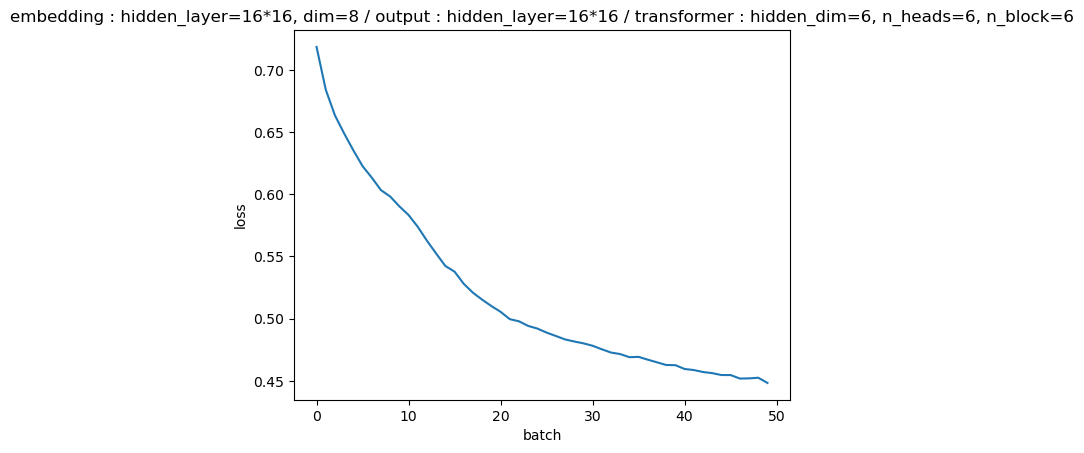

In [21]:
plt.plot(save_loss_list, label = 'loss')

plt.xlabel('batch')
plt.ylabel('loss')
plt.title('embedding : hidden_layer=16*16, dim=8 / output : hidden_layer=16*16 / transformer : hidden_dim=6, n_heads=6, n_block=6')

plt.show()


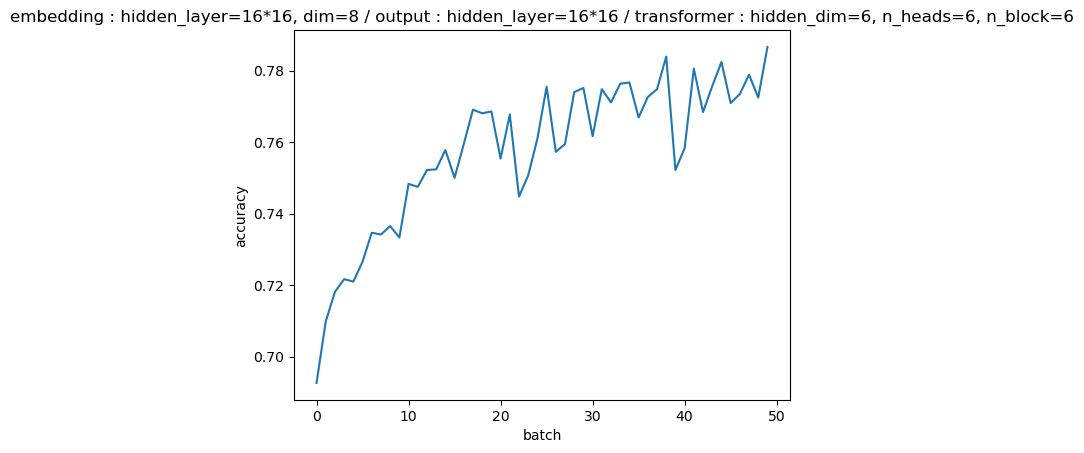

In [22]:
plt.plot(save_acc_list, label = 'accuracy')

plt.xlabel('batch')
plt.ylabel('accuracy')
plt.title('embedding : hidden_layer=16*16, dim=8 / output : hidden_layer=16*16 / transformer : hidden_dim=6, n_heads=6, n_block=6')

plt.show()

In [ ]:
print(success_rate_2(modelisation_joueur, training_data))
#lloss=[0.6218771100607697, 0.6868669817690749, 0.6022957461174882, 0.6919311276164753, 0.7086428089128967, 0.7069547602970966, 0.6954760297096556, 0.7207967589466576, 0.7207967589466576, 0.7174206617150574, 0.7253544902093181, 0.7120189061444969, 0.7253544902093181, 0.7177582714382175, 0.7370020256583389, 0.7238352464550979, 0.7354827819041189, 0.736833220796759, 0.737508440243079, 0.7337947332883187, 0.7398717083051992, 0.7410533423362593, 0.7491559756920999, 0.7454422687373397, 0.7407157326130993, 0.7493247805536799, 0.7148885887913572, 0.75050641458474, 0.75016880486158, 0.7513504388926401, 0.74966239027684, 0.7493247805536799, 0.75033760972316, 0.7559081701553004, 0.7449358541525996, 0.75050641458474, 0.7586090479405807, 0.7569209993247805, 0.7435854152599595, 0.7567521944632005, 0.75033760972316, 0.7532072923700203, 0.7606347062795409, 0.7589466576637407, 0.7552329507089804, 0.7454422687373397, 0.7481431465226198, 0.7597906819716408, 0.7469615124915597, 0.7445982444294396, 0.7592842673869007, 0.7548953409858203, 0.7510128291694801, 0.7548953409858203, 0.7451046590141797, 0.74966239027684, 0.7564145847400405, 0.7444294395678596, 0.7393652937204591, 0.7523632680621202, 0.75, 0.7451046590141797, 0.7579338284942606, 0.7445982444294396, 0.7407157326130993, 0.7434166103983795, 0.7467927076299797, 0.7469615124915597, 0.7427413909520594, 0.7560769750168805, 0.7402093180283592, 0.7405469277515192, 0.7471303173531397, 0.7481431465226198, 0.74983119513842, 0.7555705604321404, 0.7424037812288994, 0.7520256583389602, 0.7545577312626603, 0.7560769750168805, 0.7488183659689399, 0.7557393652937204, 0.7592842673869007, 0.7481431465226198, 0.7466239027683997, 0.7481431465226198, 0.7513504388926401, 0.7476367319378798, 0.7471303173531397, 0.7439230249831195, 0.7575962187711006, 0.7444294395678596, 0.7343011478730588, 0.7547265361242403, 0.7469615124915597, 0.7420661715057394, 0.7582714382174207, 0.7548953409858203, 0.7562457798784605, 0.7570898041863605, 0.7418973666441594, 0.7591154625253207, 0.7683997299122215, 0.763504388926401, 0.7645172180958811, 0.7587778528021607, 0.7640108035111411, 0.6804523970290345, 0.7699189736664416, 0.7641796083727211, 0.761985145172181, 0.7709318028359217, 0.7724510465901417, 0.7734638757596218, 0.7645172180958811, 0.7645172180958811, 0.762153950033761, 0.7516880486158002, 0.7640108035111411, 0.7646860229574611, 0.7662052667116813, 0.7656988521269412, 0.7667116812964213, 0.7626603646185011, 0.7611411208642809, 0.7775151924375422, 0.7763335584064821, 0.7451046590141797, 0.761816340310601, 0.7520256583389602, 0.7724510465901417, 0.7699189736664416, 0.7646860229574611, 0.7653612424037812, 0.7608035111411209, 0.7700877785280216, 0.7587778528021607, 0.7678933153274814, 0.7591154625253207, 0.7653612424037812, 0.7675557056043214, 0.7689061444969615, 0.7683997299122215, 0.7741390952059419, 0.7805536799459825, 0.7483119513841998, 0.7743079000675219, 0.7763335584064821, 0.7650236326806212, 0.7716070222822418, 0.7628291694800811, 0.7675557056043214, 0.7645172180958811, 0.7687373396353815, 0.7687373396353815, 0.7640108035111411, 0.7731262660364618, 0.7660364618501013, 0.7660364618501013, 0.7589466576637407, 0.7687373396353815, 0.7788656313301823, 0.7712694125590817, 0.761985145172181, 0.7739702903443619, 0.7648548278190412, 0.7665428764348413, 0.7712694125590817, 0.7672180958811614, 0.7700877785280216, 0.7653612424037812, 0.7702565833896016, 0.7673869007427414, 0.7694125590817016, 0.7731262660364618, 0.7695813639432816, 0.7663740715732613, 0.7712694125590817, 0.7778528021607022, 0.7721134368669818, 0.7704253882511817, 0.7646860229574611, 0.7817353139770425, 0.7690749493585415, 0.7746455097906819, 0.7668804861580013, 0.7743079000675219, 0.7714382174206618, 0.7700877785280216, 0.7738014854827819, 0.7645172180958811, 0.774814314652262, 0.7626603646185011, 0.774983119513842, 0.7343011478730588, 0.7673869007427414, 0.774983119513842, 0.7694125590817016, 0.7604659014179609, 0.7722822417285617, 0.7687373396353815, 0.7645172180958811, 0.7690749493585415, 0.7670492910195814, 0.7564145847400405, 0.7694125590817016, 0.7602970965563808, 0.7629979743416611, 0.7677245104659014, 0.7687373396353815, 0.7707629979743417, 0.7461174881836596, 0.774814314652262, 0.7670492910195814, 0.7738014854827819, 0.7675557056043214, 0.7731262660364618, 0.7722822417285617, 0.7611411208642809, 0.7788656313301823, 0.7650236326806212, 0.7655300472653612, 0.7672180958811614, 0.7640108035111411, 0.7721134368669818, 0.762491559756921, 0.7785280216070223, 0.7744767049291019, 0.7705941931127617, 0.7670492910195814, 0.7687373396353815, 0.7768399729912221, 0.7651924375422012, 0.7790344361917623, 0.7683997299122215, 0.7729574611748818, 0.7584402430790007, 0.7771775827143822, 0.7768399729912221, 0.774814314652262, 0.7537137069547603, 0.7628291694800811, 0.7700877785280216, 0.7734638757596218, 0.763504388926401, 0.7604659014179609, 0.7731262660364618, 0.7520256583389602, 0.7655300472653612, 0.7672180958811614, 0.7670492910195814, 0.7653612424037812, 0.7741390952059419, 0.775489534098582, 0.7704253882511817, 0.7719446320054018, 0.763166779203241, 0.7793720459149224, 0.7640108035111411, 0.774814314652262, 0.7650236326806212, 0.7716070222822418, 0.7663740715732613, 0.7744767049291019, 0.7682309250506415, 0.7714382174206618, 0.7739702903443619, 0.7773463875759622, 0.7739702903443619, 0.7692437542201216, 0.7766711681296421, 0.7726198514517219, 0.7702565833896016, 0.7655300472653612, 0.762322754895341, 0.7697501688048616, 0.7707629979743417, 0.7204591492234976, 0.7672180958811614, 0.7702565833896016, 0.7629979743416611, 0.774983119513842, 0.763504388926401, 0.7645172180958811, 0.763504388926401, 0.7778528021607022, 0.7834233625928426, 0.7675557056043214, 0.7663740715732613, 0.7776839972991222, 0.7682309250506415, 0.7699189736664416, 0.7783592167454423, 0.7761647535449021, 0.7726198514517219, 0.7678933153274814, 0.761647535449021, 0.7601282916948008, 0.7655300472653612, 0.7717758271438218]
#lacc=[0.9574471343966091, 0.8038731010826042, 0.7602433447566483, 0.7360106492438889, 0.7219753340077217, 0.7013408597320547, 0.6962473347516316, 0.6915813064788614, 0.6782550998889577, 0.6715615016725057, 0.6692469445488337, 0.6668281284210932, 0.6647348281977427, 0.6567231369445391, 0.6461521421399568, 0.6459748619200324, 0.6419916519957125, 0.6409536333721312, 0.633803602069845, 0.6328610110160945, 0.6302519143771028, 0.622586085439643, 0.618641789611953, 0.6122862961514831, 0.6072832080904785, 0.6037898522127619, 0.6049849766370891, 0.6017320025569338, 0.5975894109939065, 0.6010657591206948, 0.5978157622430026, 0.5958626023338883, 0.5953634487241125, 0.591292240735515, 0.5930543576207612, 0.5851691331323761, 0.5827686105047345, 0.5789401669179082, 0.5768412573029623, 0.5771893037630774, 0.5720234815688694, 0.5729973192524422, 0.5757266985219153, 0.5690784790479314, 0.5690852325895558, 0.5665320959085088, 0.5620714515409506, 0.5613163483074254, 0.5592851606209565, 0.5589237430745073, 0.5597501949352377, 0.5531276908638837, 0.5524014173185124, 0.5513559174354729, 0.5475932630469732, 0.5454079706955444, 0.5478139642978568, 0.5410932554384632, 0.5391562124499885, 0.5372526733123738, 0.5372692905080593, 0.5312460663602175, 0.5304741107518106, 0.5273137946453545, 0.5304980915220802, 0.5334532521188716, 0.5265231576683881, 0.5232528025841774, 0.5274586744434998, 0.5327209313697827, 0.5223012647741591, 0.5203172410731121, 0.5216255122057313, 0.5191819152563734, 0.5197249944214626, 0.5176789497056276, 0.5186484015696798, 0.5188514812637472, 0.5162537026855037, 0.5169761269674886, 0.513450992458007, 0.5129512495854321, 0.5111721435280712, 0.5137336796430676, 0.5132320899220989, 0.5105899937279389, 0.5102441426166489, 0.5083269645338473, 0.5089307147294969, 0.507587369769583, 0.5067653884287076, 0.5082727840070225, 0.508887190247893, 0.5081335821991686, 0.5078393293692328, 0.5072074187609851, 0.5069308009027215, 0.5083637362932001, 0.5047280352057704, 0.5044370343351303, 0.5055715055073924, 0.5033116945449043, 0.504385788879736, 0.5054014191565002, 0.5018653557695392, 0.5024072061604856, 0.5093147961989694, 0.5231759959207777, 0.5171662558565664, 0.5023697743292355, 0.5005221023698292, 0.5019724108374027, 0.5358972797346542, 0.49560523107457344, 0.49567292513483013, 0.49707822128177603, 0.4968446629965092, 0.4974413974510739, 0.4953131389320659, 0.49656861271623454, 0.49553576550062967, 0.5035451879091275, 0.49620840982402986, 0.49518674448170624, 0.49497181230493825, 0.49661560751059475, 0.5017515277237539, 0.4946453639537172, 0.4936848236509906, 0.4974497119369714, 0.4914839943237317, 0.49094185316959, 0.48863872853310214, 0.49025426926972615, 0.48978416768410016, 0.4930195346893862, 0.4894662809455791, 0.4955546465676154, 0.4934907310149249, 0.49517754964587635, 0.4928123677135124, 0.49036085817133984, 0.48770796147453815, 0.48532580206994813, 0.48799225015332326, 0.48727047447200933, 0.4863899781194794, 0.4854433445255165, 0.4843683498518546, 0.4831568634761569, 0.4823381458325764, 0.48660694714397423, 0.48649139890966514, 0.4809553130241611, 0.48358474902408505, 0.48122788786583237, 0.4829696920483618, 0.4929056573287605, 0.48680387957550375, 0.48147035106216246, 0.47888737391023073, 0.48063849246181795, 0.49337042971035405, 0.48090962995120023, 0.48089070964957137, 0.47885790436773956, 0.4787278115901801, 0.47887898781491667, 0.47932507044366557, 0.48088760565385186, 0.4776025506693994, 0.48179473691736646, 0.48808740763484365, 0.4777911528944969, 0.4772287198459096, 0.47653022082641605, 0.47860448420657525, 0.4793790541493984, 0.4773420417857597, 0.47537129991652105, 0.47986306002377854, 0.4761394264219362, 0.47611033621117893, 0.4758553644427863, 0.47636510466065857, 0.47507345624973096, 0.4829751496653423, 0.4741786746379664, 0.4743649879913501, 0.4761458099879267, 0.47295586964892, 0.4774478142866698, 0.4735534308321031, 0.4748640337296764, 0.549152435853963, 0.4990102514014829, 0.4876863481977102, 0.4855289292686126, 0.47766869989654903, 0.47693094801719843, 0.4772370621904998, 0.47830474963578423, 0.47667200392698084, 0.4762808010172661, 0.4743353227901337, 0.4793654761236647, 0.47394075772494, 0.47256498993433954, 0.47212189247312447, 0.4714093773490023, 0.4743241386302292, 0.48122158536063436, 0.49092355479136146, 0.49004896667302417, 0.4731781943260556, 0.47167021971758066, 0.4723908399300807, 0.4702614549633182, 0.47158132198140446, 0.47045516170313595, 0.47252429884565456, 0.4712188597339803, 0.47005373746385354, 0.4715208951622019, 0.46990936935481514, 0.4697556414681932, 0.4698565522366015, 0.4689421018256861, 0.47096103216376145, 0.46953687168981717, 0.4696706930351684, 0.46973048539265344, 0.47015004519306486, 0.46955237634803937, 0.4688937066461119, 0.46882746467733627, 0.4694388725644792, 0.4666946069778079, 0.47027687938012125, 0.4665386777018647, 0.4702299520411455, 0.46767360368348143, 0.4680266124779916, 0.4675370417058925, 0.4684247829382072, 0.4687173614549972, 0.4658411794801807, 0.4683562456570623, 0.46794827707359554, 0.4680092952516683, 0.4669631970927234, 0.4666679725813134, 0.4665467216040167, 0.4656814017602245, 0.4662827919034854, 0.4649257713457203, 0.46605429527780895, 0.4684640843506969, 0.4658371354917736, 0.4647832483891636, 0.46802783138154413, 0.46650966647488384, 0.4664692908068142, 0.46631191346956335, 0.4650951308553176, 0.46444876330054324, 0.4669215216508607, 0.46330079152379805, 0.46689030977771107, 0.46625361119008735, 0.46521471261673264, 0.4647985747479417, 0.4664098892903999, 0.4675174301009044, 0.46907827825954806, 0.4678981819421129, 0.4630468945826411, 0.46322090233988167, 0.47266394671652934, 0.4637769889229399, 0.4642298163755623, 0.4629743218498157, 0.46420838514252394, 0.46451045208803526, 0.4643063392213848, 0.4620938028025505, 0.4639092672168446, 0.4646188346359431, 0.4651330721652721, 0.4928697752944954, 0.46138476406979134, 0.4648869196357934, 0.46102546164980324, 0.4629415130180776, 0.461957081695042, 0.4621976743002072, 0.4629025515121267, 0.46267152724363614, 0.4619290786783409, 0.4621165123341791]
print(sum(loss_list[290:])/10)
print(sum(acc_list[290:])/10)


0.8325


NameError: name 'loss_list' is not defined